<a href="https://colab.research.google.com/github/austinpeel/jax-strong-lensing/blob/dev-egor/GRF_fitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Folder='/content/drive/My Drive/Jax_Strong_Lensing/'

import sys
sys.path.append(Folder+'/Modules')
_=!python drive/My\ Drive/Jax_Strong_Lensing/Modules/My_repo/setup.py install

Mounted at /content/drive


In [2]:
_=!pip install pyFFTW
_=!pip install powerbox
_=!pip install optax

In [437]:
# Plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline


# Basic imports
import numpy as np
from copy import deepcopy
import pandas as pd
from tqdm import tqdm

#JAX
import jax
import jax.numpy as jnp
from jax.config import config
config.update("jax_enable_x64", True)
config.update("jax_debug_nans", True)

#Jaxtronomy
from jaxtronomy.Coordinates.pixel_grid import PixelGrid
from jaxtronomy.Instrument.psf import PSF
from jaxtronomy.Instrument.noise import Noise
from jaxtronomy.LightModel.light_model import LightModel
from jaxtronomy.LensModel.lens_model import LensModel
from jaxtronomy.LensImage.lens_image import LensImage
from jaxtronomy.Parameters.parameters import Parameters
from jaxtronomy.Inference.loss import Loss
from jaxtronomy.Inference.optimization import Optimizer

#My utils
from jaxtronomy.GaussianRandomField.GRF_model import Potential_based_GRF_perturbed_lens
from jaxtronomy.GaussianRandomField.GRF_model import GRF_perturbed_lens
from jaxtronomy.GaussianRandomField.Lens_Source_model import Lens_Source_model

#GRF generator
import powerbox as pbox

# Universal font size
FS = 18

# Jaxified fitting

## jaxified powerbox

In [331]:
npix = 100
pix_scl = 0.08  # arcsec / pixel
boxlength=2 * np.pi * npix * pix_scl
dx = float(boxlength) / npix
dim=2
V=boxlength**dim
A=1
beta=7
seed=1


def get_GRF(A,beta)

pbox_class=pbox.PowerBox(N=npix, dim=dim, pk=(lambda k: A * k**(-beta)), boxlength=boxlength, seed=seed,vol_normalised_power=False)

In [712]:
def get_k_grid_dx(npix, pix_scl):
  #Throw this part outside of function
  boxlength=2 * np.pi * npix * pix_scl
  #Grid step for real-space
  dx = float(boxlength) / npix
  #wavenumbers along side
  k_vector=np.fft.fftshift(np.fft.fftfreq(npix, d=dx)) * 2 * np.pi
  #wavenumbers 2d grid
  k_grid=np.sqrt(np.sum(np.meshgrid(*([k_vector ** 2] * 2)), axis=0))

  return k_grid,dx

def get_phase_realisation(npix,seed=None):
  "A random array which has Gaussian magnitudes and Hermitian symmetry"
  if seed:
    np.random.seed(seed)

  #uneven number 
  n=npix + 1 if (npix%2==0) else npix
  #2d grid
  size=[n]*2

  magnitude=np.random.normal(0, 1, size=size)
  phase=2 * np.pi * np.random.uniform(size=size)

  #Make hermitian (why?)
  magnitude=(magnitude+magnitude[::-1,::-1])/np.sqrt(2)
  phase=(phase-phase[::-1,::-1])/2 + np.pi

  phase_realisation=magnitude * (np.cos(phase) + 1j * np.sin(phase))

  if (npix%2==0):
    #why?
    phase_realisation=phase_realisation[:-1,:-1]

  return phase_realisation

def _adjust_phase(ft, npix, pix_scl):
    #Fourier parameters
    dx = 2 * np.pi * pix_scl
    k_vector=np.fft.fftshift(np.fft.fftfreq(npix, d=dx)) * 2 * np.pi


    left_edge=k_vector[0]
    freq=np.fft.fftshift(np.fft.fftfreq(npix,d=2*np.pi/dx/npix))*2*np.pi
    #for scalar left-edge and 1row freq
    xp = np.array([np.exp( 1j * freq * left_edge)])
    #phase correction
    ft = ft * xp.T
    ft = ft * xp
    return ft

#@jax.partial(jax.jit,static_argnums=(2,3,4,5,6))
def get_GRF(A,beta,npix,pix_scl,k_grid,phase_realisation):

  #to exclude spectrum on k=0 from consideration and avoid division by zero
  k_grid[npix//2,npix//2]=np.inf

  #Power spectrum
  power_array=A*np.power(k_grid,-beta)
  #Create fourier image with random phases
  Fourier_image=np.sqrt(power_array)*phase_realisation
  #Go to configuration space
  Config_image=(npix**2)*np.fft.ifftshift(np.fft.ifftn(Fourier_image))
  
  #Adjust phases of the image
  Config_image=_adjust_phase(Config_image,npix, pix_scl)

  #Get rid of complexity
  return np.real(Config_image)


@jax.partial(jax.jit,static_argnums=(1,2,3))
def get_jaxified_GRF(params,seed,npix,pix_scl):
  A,beta=params

  k_grid,dx=get_k_grid_dx(npix,pix_scl)
  #we will do ps=k^(-beta) with gradient ps_grad=-ln(k)*k^(-beta), 
  #we want both to be 0 in center where k=0
  #So we set k=1 to avoid divergence with setting k=0 or k=inf
  k_grid[npix//2,npix//2]=1
  #In the same time we mask out the place where k=0, to exclude it from equation 
  mask_center=np.ones_like(k_grid)
  mask_center[npix//2,npix//2]=0


  #workaround: sqrt(Power spectrum) in one operation
  #Jax gets nans when we do operations separately like sqrt(power*mask)
  sqrt_power_array=jnp.sqrt(A)*jnp.power(k_grid,-beta/2.)*mask_center
  #Random phase realisation in Fourier space
  phase_realisation=get_phase_realisation(npix,seed)
  
  #Create fourier image with random phases
  Fourier_image=sqrt_power_array*phase_realisation
  #Fourier_image=power_array*phase_realisation
  #Go to configuration space
  Config_image=(npix**2)*jnp.fft.ifftshift(jnp.fft.ifftn(Fourier_image))
  
  #Adjust phases of the image
  Config_image=_adjust_phase(Config_image,npix, pix_scl)
  #Get rid of complexity
  return jnp.real(Config_image)


@jax.partial(jax.jit,static_argnums=(1,2,3))
def get_GRF_variance(params,seed,npix,pix_scl):
  GRF=get_jaxified_GRF(params,seed,npix,pix_scl)
  return jnp.std(GRF)

In [704]:
GRF=get_jaxified_GRF([A,beta],seed,npix,pix_scl)
get_GRF_variance_grad=jax.grad(get_GRF_variance)
get_GRF_variance_grad([1.,5.],seed,npix,pix_scl)

[DeviceArray(1.1015143, dtype=float64), DeviceArray(1.83537036, dtype=float64)]

In [691]:
GRF_std=(lambda parameters: jnp.std(get_jaxified_GRF(parameters,seed,npix,pix_scl)))
jax.grad(GRF_std)([1.,5.])

[DeviceArray(220.31397733, dtype=float64),
 DeviceArray(183.54880537, dtype=float64)]

In [713]:
get_GRF(A,beta,npix,pix_scl,k_grid,phase_realisation)

array([[-0.63728123, -0.62000464, -0.58696678, ..., -0.6469681 ,
        -0.63809252, -0.63455591],
       [-0.56369797, -0.59004928, -0.59081205, ..., -0.52070096,
        -0.52554516, -0.53616245],
       [-0.49730019, -0.53888398, -0.56107177, ..., -0.41180063,
        -0.43251754, -0.46414928],
       ...,
       [-0.74592029, -0.71183601, -0.66764842, ..., -0.85394024,
        -0.82620139, -0.78715847],
       [-0.71886435, -0.68221421, -0.65176374, ..., -0.79562526,
        -0.77643399, -0.75044908],
       [-0.69471897, -0.64380103, -0.61616664, ..., -0.73979098,
        -0.73590224, -0.72451219]])

In [714]:
get_jaxified_GRF([A,beta],seed,npix,pix_scl)

DeviceArray([[-0.63728123, -0.62000464, -0.58696678, ..., -0.6469681 ,
              -0.63809252, -0.63455591],
             [-0.56369797, -0.59004928, -0.59081205, ..., -0.52070096,
              -0.52554516, -0.53616245],
             [-0.49730019, -0.53888398, -0.56107177, ..., -0.41180063,
              -0.43251754, -0.46414928],
             ...,
             [-0.74592029, -0.71183601, -0.66764842, ..., -0.85394024,
              -0.82620139, -0.78715847],
             [-0.71886435, -0.68221421, -0.65176374, ..., -0.79562526,
              -0.77643399, -0.75044908],
             [-0.69471897, -0.64380103, -0.61616664, ..., -0.73979098,
              -0.73590224, -0.72451219]], dtype=float64)

In [690]:
pix_scl

0.08

In [692]:
npix=100
pix_scl = 0.08  # arcsec / pixel

A=1e-5
beta=5.
seed=1

#Preparing data for GRF
k_grid,dx=get_k_grid_dx(npix,pix_scl)
phase_realisation=get_phase_realisation(npix,seed)
dx = 2 * np.pi * pix_scl
k_vector=np.fft.fftshift(np.fft.fftfreq(npix, d=dx)) * 2 * np.pi

#Traced GRF creation
GRF=get_GRF(A,beta,npix,pix_scl,k_grid,phase_realisation)
GRF_pbox=pbox.PowerBox(N=npix, dim=2, pk=(lambda k: A * k**(-beta)), boxlength=2 * np.pi * npix * pix_scl, seed=seed,vol_normalised_power=False).delta_x()

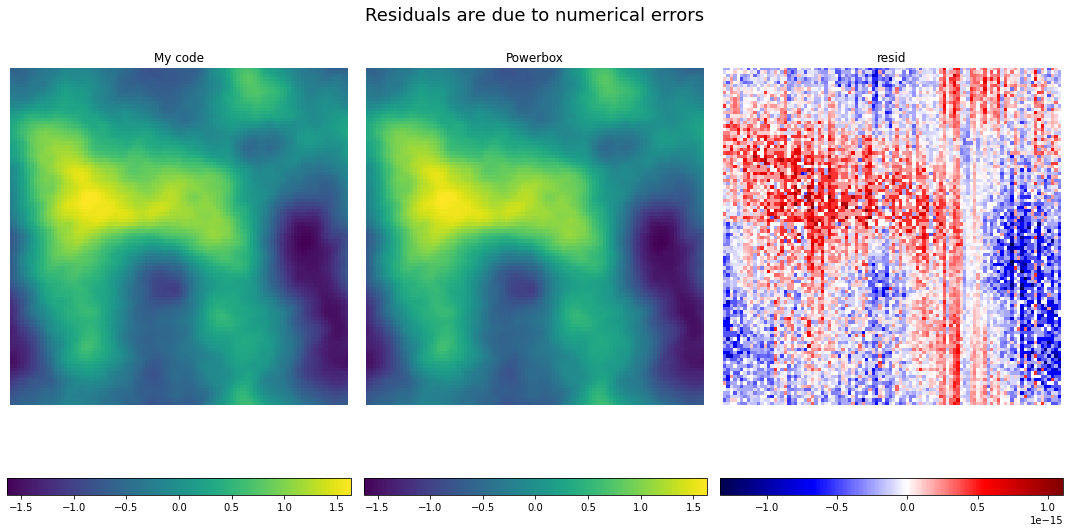

In [693]:
fig,ax=plt.subplots(1,3,figsize=(15,7))

im0=ax[0].imshow(GRF)
im1=ax[1].imshow(GRF_pbox)
im2=ax[2].imshow(GRF-GRF_pbox,cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))

names=['My code','Powerbox','resid']
for i,im in enumerate([im0,im1,im2]):
  ax[i].set_title(names[i])
  ax[i].axis('off')
  fig.colorbar(im,ax=ax[i],orientation='horizontal')

fig.tight_layout()
fig.suptitle('Residuals are due to numerical errors',y=1.1,fontsize=FS)
plt.show()

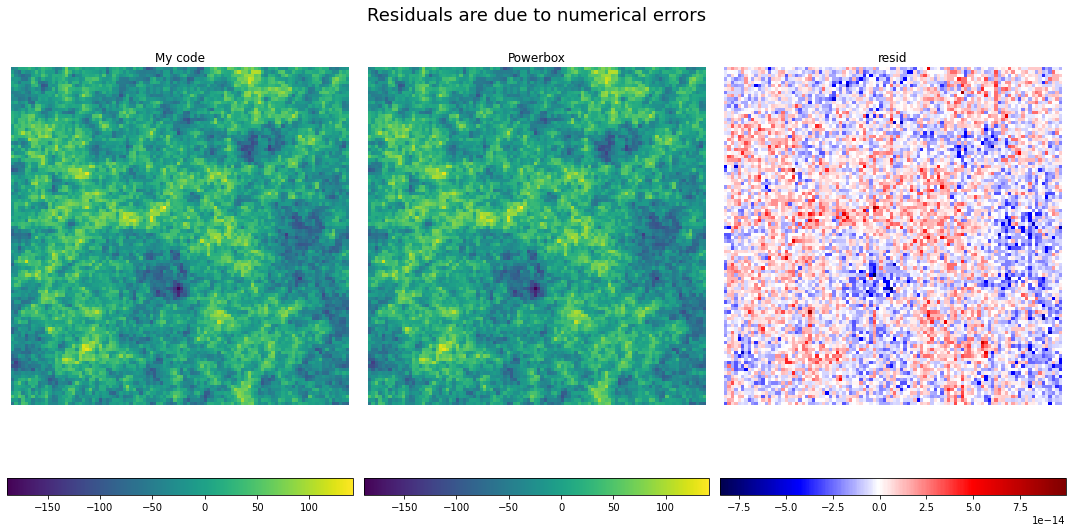

In [363]:
npix=100
pix_scl = 0.08  # arcsec / pixel

A=1
beta=2
seed=1

#Preparing data for GRF
k_grid,dx=get_k_grid_dx(npix,pix_scl)
phase_realisation=get_phase_realisation(npix,seed)
dx = 2 * np.pi * pix_scl
k_vector=np.fft.fftshift(np.fft.fftfreq(npix, d=dx)) * 2 * np.pi

#Traced GRF creation
GRF=get_GRF(A,beta,npix,k_grid,phase_realisation,dx,k_vector)
GRF_pbox=pbox.PowerBox(N=npix, dim=2, pk=(lambda k: A * k**(-beta)), boxlength=2 * np.pi * npix * pix_scl, seed=seed,vol_normalised_power=False).delta_x()

fig,ax=plt.subplots(1,3,figsize=(15,7))

im0=ax[0].imshow(GRF)
im1=ax[1].imshow(GRF_pbox)
im2=ax[2].imshow(GRF-GRF_pbox,cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))

names=['My code','Powerbox','resid']
for i,im in enumerate([im0,im1,im2]):
  ax[i].set_title(names[i])
  ax[i].axis('off')
  fig.colorbar(im,ax=ax[i],orientation='horizontal')

fig.tight_layout()
fig.suptitle('Residuals are due to numerical errors',y=1.1,fontsize=FS)
plt.show()

## Data grids

In [ ]:
npix = 100
pix_scl = 0.08  # arcsec / pixel
half_size = npix * pix_scl / 2
ra_at_xy_0 = dec_at_xy_0 = -half_size + pix_scl / 2
transform_pix2angle = pix_scl * np.eye(2)
kwargs_pixel = {'nx': npix, 'ny': npix,
                'ra_at_xy_0': ra_at_xy_0, 'dec_at_xy_0': dec_at_xy_0,
                'transform_pix2angle': transform_pix2angle}
pixel_grid = PixelGrid(**kwargs_pixel)
xgrid, ygrid = pixel_grid.pixel_coordinates
x_coords = xgrid[0, :]
y_coords = ygrid[:, 0]

print(f"image size : ({npix}, {npix}) pixels")
print(f"pixel size : {pix_scl} arcsec")
print(f"x range    : {xgrid[0, 0], xgrid[0, -1]} arcsec")
print(f"y range    : {ygrid[0, 0], ygrid[-1, 0]} arcsec")

image size : (100, 100) pixels
pixel size : 0.08 arcsec
x range    : (-3.96, 3.96) arcsec
y range    : (-3.96, 3.96) arcsec


## Source light model

In [ ]:
source_light_model_list = ['SERSIC_ELLIPSE']
source_light_model = LightModel(source_light_model_list)
kwargs_source_light = [{'amp': 10.0, 'R_sersic': 1.2, 'n_sersic': 1.5, 'center_x': 0.4, 'center_y': 0.15,'e1':0.07,'e2':-0.1}]

## Lens model (SIE + external shear)

In [ ]:
#Seed=0 is treated like abscence of seed. Use 1 or more
def get_GRF_potential(A,beta,npix=npix,pix_scl=pix_scl,seed=1):

    #2*pi*number_pix*pix_scale
    box_length = 2 * np.pi * npix * pix_scl
    return pbox.PowerBox(N=npix, dim=2, pk=(lambda k: A * k**(-beta)), boxlength=box_length, seed=seed).delta_x()

In [ ]:
# Lens mass
lens_mass_model_list = ['SIE', 'SHEAR','PIXELATED']
lens_mass_model = LensModel(lens_mass_model_list)

GRF_Amp=1e-4
GRF_beta=2
GRF_seed=1
GRF_realisation=deepcopy(get_GRF_potential(GRF_Amp,GRF_beta,seed=GRF_seed))
kwargs_lens_mass = [{'theta_E': 1.6, 'e1': 0.15, 'e2': -0.04, 'center_x': 0.0, 'center_y': 0.0},\
                    {'gamma1': -0.01, 'gamma2': 0.03, 'ra_0': 0.0, 'dec_0': 0.0},\
                    {'x_coords': x_coords, 'y_coords': y_coords, 'psi_grid': GRF_realisation}]

# Lens light
lens_light_model_list = []
lens_light_model = LightModel(lens_light_model_list)
kwargs_lens_light = [{}]

## Observation conditions

In [ ]:
kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': 0.3}
psf = PSF(**kwargs_psf)

exp_time = 2028
SNR=100

In [ ]:
#SNR-defined noise
kwargs_numerics = {'supersampling_factor': 1}
lens_image = LensImage(pixel_grid, psf, noise_class={'background_rms': np.zeros((npix, npix)), 'exposure_time': exp_time},
                         lens_model_class=lens_mass_model,
                         source_model_class=source_light_model,
                         lens_light_model_class=lens_light_model,
                         kwargs_numerics=kwargs_numerics)

image=lens_image.model(kwargs_lens=kwargs_lens_mass,
                          kwargs_source=kwargs_source_light,
                          kwargs_lens_light=kwargs_lens_light)

Peak_signal=np.abs(image).max()
sigma_bkd = Peak_signal/SNR
noise_map = sigma_bkd * np.ones((npix, npix))
noise = Noise(npix, npix, **{'background_rms': sigma_bkd, 'exposure_time': exp_time})

## Image model

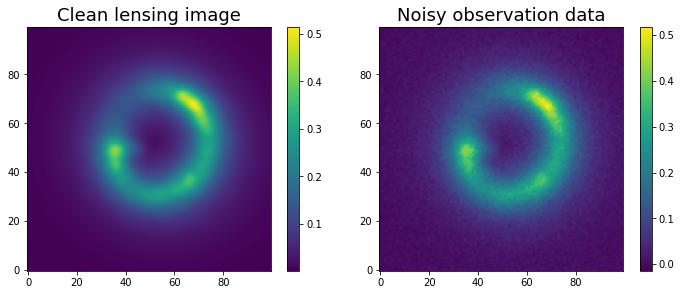

In [ ]:
# Generate a lensed image based on source and lens models
kwargs_numerics = {'supersampling_factor': 1}
lens_image = LensImage(pixel_grid, psf, noise_class=noise,
                         lens_model_class=lens_mass_model,
                         source_model_class=source_light_model,
                         lens_light_model_class=lens_light_model,
                         kwargs_numerics=kwargs_numerics)

image = lens_image.model(kwargs_lens=kwargs_lens_mass,
                          kwargs_source=kwargs_source_light,
                          kwargs_lens_light=kwargs_lens_light)

true_source = lens_image.source_surface_brightness(kwargs_source=kwargs_source_light, 
                                                   de_lensed=True, unconvolved=True)

# Observed noisy data
data = lens_image.simulation(kwargs_lens=kwargs_lens_mass,
                              kwargs_source=kwargs_source_light,
                              kwargs_lens_light=kwargs_lens_light)

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
img1 = ax1.imshow(image, origin='lower')
ax1.set_title("Clean lensing image", fontsize=FS)
img2 = ax2.imshow(data, origin='lower')
ax2.set_title("Noisy observation data", fontsize=FS)
for img, ax in zip((img1, img2), (ax1, ax2)):
    fig.colorbar(img, ax=ax)
fig.tight_layout()

## Mask

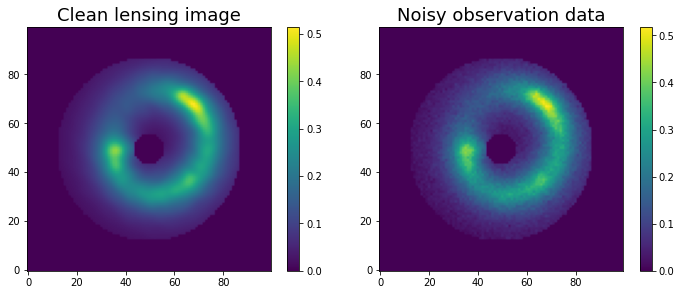

In [ ]:
rmin = 0.5
rmax = 3
radius = np.hypot(xgrid, ygrid)
#Mask covering Einstein ring
mask = ((radius >= rmin) & (radius <= rmax)).astype(bool)

#Account for frequencies present according to size of masked region 
k=np.fft.fftshift(np.fft.fftfreq(npix,pix_scl))[npix//2:]
mask_spectral_cut_index=np.where(k>1/(rmax-rmin))[0][0]
masked_k=k[mask_spectral_cut_index:]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
img1 = ax1.imshow(image*mask, origin='lower')
ax1.set_title("Clean lensing image", fontsize=FS)
img2 = ax2.imshow(data*mask, origin='lower')
ax2.set_title("Noisy observation data", fontsize=FS)
for img, ax in zip((img1, img2), (ax1, ax2)):
    fig.colorbar(img, ax=ax)
fig.tight_layout()

## Jnp-traced GRF

# Non-Jaxified fitting

In [ ]:
def get_parameters(kwargs):

  kwargs_model = {
    'lens_model_list': lens_mass_model_list[:-1],
    'source_model_list': source_light_model_list,
    'lens_light_model_list': [],
  }

  kwargs_init = {
    'kwargs_lens': kwargs['kwargs_lens'],
    'kwargs_source': kwargs['kwargs_source'],
  }


  #Priors from this article Park et al. 2021 Table 1 (Partially)
  '''
  kwargs_prior = {
    'kwargs_lens': [{'theta_E': ['gaussian', 1.1, 0.1], 'e1': ['gaussian', 0, 0.2], 'e2': ['gaussian', 0, 0.2], \
                     'center_x': ['gaussian', 0, 0.07], 'center_y': ['gaussian', 0, 0.07]}, {'gamma1': ['uniform', -0.05, 0.05], 'gamma2': ['uniform', -0.05, 0.05]}],
                  
    'kwargs_source': [{'amp': ['uniform',5.0,20.0], 'R_sersic': ['uniform',1e-3,5.], 'n_sersic': ['gaussian',3,0.5],\
                       'center_x': ['uniform', -1.0, 1.0], 'center_y': ['uniform', -1.0, 1.0],'e1': ['gaussian', 0, 0.2], 'e2': ['gaussian', 0, 0.2]}],
  }
  '''

  kwargs_prior = {
    'kwargs_lens': [{'theta_E': ['uniform', 1., 2.], 'e1': ['gaussian', 0, 0.2], 'e2': ['gaussian', 0, 0.2], \
                     'center_x': ['gaussian', 0, 0.102], 'center_y': ['gaussian', 0, 0.102]}, {'gamma1': ['uniform', -0.5, 0.5], 'gamma2': ['uniform', -0.5, 0.5]}],
                  
    'kwargs_source': [{'amp': ['uniform',5.0,20.0], 'R_sersic': ['uniform',1e-3,5.], 'n_sersic': ['uniform',1e-3,4.0],\
                       'center_x': ['uniform', -1.0, 1.0], 'center_y': ['uniform', -1.0, 1.0],'e1': ['gaussian', 0, 0.2], 'e2': ['gaussian', 0, 0.2]}],
  }
  
  kwargs_fixed = {
    'kwargs_lens': [{}, {'ra_0': 0., 'dec_0': 0.}],  # fix origin of the external shear profile
    'kwargs_source': [{}],  # fix all source parameters
    }

  parameters = Parameters(kwargs_model, kwargs_init, kwargs_prior, kwargs_fixed)

  return parameters

In [ ]:
def get_model(kwargs):


  # Generate a lensed image based on source and lens models
  #Source light from simulation
  #Lens mass except for PIXELATED GRF from simulation
  lens_image = LensImage(data_class=pixel_grid,
                         psf_class=psf,
                         noise_class=noise,
                         lens_model_class=LensModel(lens_mass_model_list[:-1]),
                         source_model_class=source_light_model,
                         lens_light_model_class=LightModel([]),
                         kwargs_numerics={'supersampling_factor': 1})
  
  #To calculate noise map for the first time
  '''
  _= lens_image.simulation(compute_true_noise_map=True,
                             kwargs_lens=kwargs['kwargs_lens'],
                             kwargs_source=kwargs['kwargs_source'],
                             kwargs_lens_light=kwargs['kwargs_lens_light'])
  '''

  kwargs_true = {'kwargs_lens': kwargs_lens_mass[:-1], 'kwargs_source': kwargs_source_light}

  return lens_image,kwargs_true

In [ ]:
def fit_data(data,lens_image,parameters):

  parameters=deepcopy(parameters)

  loss = Loss(data, lens_image, parameters)
  grad_loss = jax.jit(jax.grad(loss))

  optimizer = Optimizer(loss, parameters)
  #BFGS for gradient only, Newton-CG for graident+ hessian vector product
  #BFGS is faster since it doesn't compute hessian vp
  best_fit, logL, extra_fields, runtime \
    = optimizer.minimize(method='BFGS', restart_from_init=True,
                         use_exact_hessian_if_allowed=False)
    
  kwargs_final = deepcopy(parameters.ML_values(as_kwargs=True))
  if extra_fields['hess_inv'] is not None:
    fisher_matrix = extra_fields['hess_inv']
  else:
    hess_ml = optimizer.hessian(best_fit)
    fisher_matrix = jax.numpy.linalg.inv(hess_ml)

  return parameters.kwargs2args(kwargs_final),fisher_matrix

In [ ]:
def Radial_profile(image,q=1,x0=None,y0=None,phi=0):
    x0=image.shape[1]/2
    y0=image.shape[0]/2


    R_max=image.shape[0]//2
    radial_profile=np.zeros(R_max)
    counter=np.zeros(R_max)
    for y in range(image.shape[0]):
        for x in range(image.shape[1]):
            R=np.sqrt(np.power(x-x0,2)+np.power(y-y0,2))
            #Account only unmasked values 
            if (R<R_max):
                radial_profile[int(R)]+=image[y,x]
                counter[int(R)]+=1

    radial_profile=radial_profile/counter
    #radial_profile[mask_nan]=0

    #Radial profile is average Flux in a ring of radius R
    return radial_profile

def compute_radial_spetrum(image,pix_scl=pix_scl,mask=mask):
  #Scales larger than the size of the masked region (Einstein ring)
  masked_image=image*mask

  spectrum=np.fft.fft2(masked_image)
  half_im_size=image.shape[0]//2
  Centered_Spectrum=np.roll(np.abs(spectrum)**2,half_im_size,axis=(0,1))
  
  return Radial_profile(Centered_Spectrum)[mask_spectral_cut_index:]

In [ ]:
def external_mean_SE(data,fit_samples,Poisson_err=False):
  if Poisson_err:
    return np.nanmean(np.power((data-fit_samples)/fit_samples,2),axis=(0,-1))
  else:
    return np.nanmean(np.power((data-fit_samples),2),axis=(0,-1))

### First fit

In [ ]:
kwargs_true={'kwargs_lens':kwargs_lens_mass[:-1],'kwargs_lens_light':kwargs_lens_light,'kwargs_source':kwargs_source_light}

In [ ]:
smooth_lens_image,_=get_model(kwargs_true)
parameters=get_parameters(kwargs_true)
args0,fisher_matrix0=fit_data(image,smooth_lens_image,parameters)

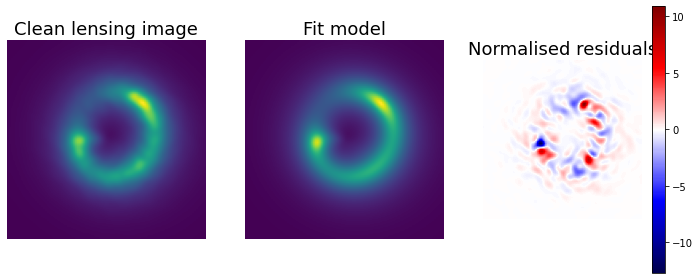

In [ ]:
kwargs0=parameters.args2kwargs(args0)
model0=smooth_lens_image.model(kwargs_lens=kwargs0['kwargs_lens'],
                          kwargs_source=kwargs0['kwargs_source'],
                          kwargs_lens_light=kwargs0['kwargs_lens_light'])

# Plot
fig, ax = plt.subplots(1, 3, figsize=(10, 4))
ax[0].imshow(image, origin='lower')
ax[0].set_title("Clean lensing image", fontsize=FS)

ax[1].imshow(model0, origin='lower')
ax[1].set_title("Fit model", fontsize=FS)

resid0=(image-model0)
im=ax[2].imshow(resid0/sigma_bkd,origin='lower',cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))
ax[2].set_title("Normalised residuals", fontsize=FS)

for i in range(3):
  ax[i].axis('off')


fig.colorbar(im, ax=ax[-1])
fig.tight_layout()
plt.show()

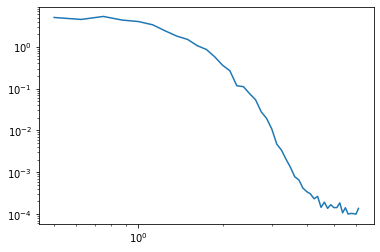

In [ ]:
resid0_spectrum=compute_radial_spetrum(resid0)
plt.loglog(masked_k,resid0_spectrum)

## Simulation and second fit

In [ ]:
fit_Amplitude=1.2e-4
fit_Beta=1.6
fit_GRF=deepcopy(get_GRF_potential(GRF_Amp,GRF_beta,seed=GRF_seed))

#kwargs_lens_mass_sim = kwargs0['kwargs_lens']+[{'x_coords': x_coords, 'y_coords': y_coords, 'psi_grid': fit_GRF}]
kwargs_lens_mass_sim = kwargs_true['kwargs_lens']+[{'x_coords': x_coords, 'y_coords': y_coords, 'psi_grid': fit_GRF}]

image_sim=lens_image.model(kwargs_lens=kwargs_lens_mass_sim,
                          kwargs_source=kwargs_true['kwargs_source'],
                          kwargs_lens_light=kwargs_true['kwargs_lens_light'])

smooth_lens_image,_=get_model(kwargs_true)
parameters=get_parameters(kwargs_true)
args1,fisher_matrix1=fit_data(image_sim,smooth_lens_image,parameters)

In [ ]:
kwargs1=parameters.args2kwargs(args1)
model1=smooth_lens_image.model(kwargs_lens=kwargs1['kwargs_lens'],
                          kwargs_source=kwargs1['kwargs_source'],
                          kwargs_lens_light=kwargs1['kwargs_lens_light'])

resid1=(image_sim-model1)
resid1_spectrum=compute_radial_spetrum(resid1)

loss=np.mean(np.power((resid0_spectrum-resid1_spectrum)/resid1_spectrum,2))

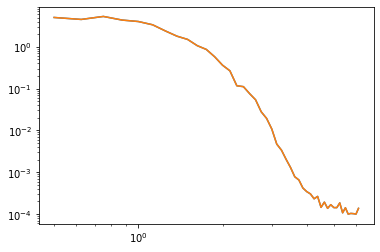

In [ ]:
plt.loglog(masked_k,resid0_spectrum)
plt.loglog(masked_k,resid1_spectrum)


In [ ]:
from scipy.optimize import minimize
from scipy.optimize import curve_fit
def GRF_Loss(x,seed,kwargs0,lens_image,resid0_spectrum):
  fit_Amplitude,fit_Beta=x
  fit_GRF=deepcopy(get_GRF_potential(fit_Amplitude,fit_Beta,seed=seed))

  kwargs_lens_mass_sim = kwargs0['kwargs_lens']+[{'x_coords': x_coords, 'y_coords': y_coords, 'psi_grid': fit_GRF}]

  image_sim=lens_image.model(kwargs_lens=kwargs_lens_mass_sim,
                          kwargs_source=kwargs0['kwargs_source'],
                          kwargs_lens_light=kwargs0['kwargs_lens_light'])

  smooth_lens_image,kwargs_true=get_model(kwargs0)
  parameters=get_parameters(kwargs0)
  args1,fisher_matrix1=fit_data(image_sim,smooth_lens_image,parameters)

  kwargs1=parameters.args2kwargs(args1)
  model1=smooth_lens_image.model(kwargs_lens=kwargs1['kwargs_lens'],
                          kwargs_source=kwargs1['kwargs_source'],
                          kwargs_lens_light=kwargs1['kwargs_lens_light'])
  
  resid1=(image_sim-model1)
  resid1_spectrum=compute_radial_spetrum(resid1)

  loss=np.mean(np.power((resid0_spectrum-resid1_spectrum)/resid1_spectrum,2))
  print('loss',loss)
  print('fit_Amplitude',fit_Amplitude)
  print('fit_Beta',fit_Beta)
  return loss

In [ ]:
popt,_ = curve_fit(lambda k,A,beta: A*np.power(k,-beta),masked_k,resid0_spectrum)

In [ ]:
popt

array([2.4328652 , 1.44464997])

In [ ]:

fit_Amplitude=1.2e-4
fit_Beta=1.44
fit_seed=2
bounds=[(1e-5,1),(1e-3,3)]
res=minimize(fun=GRF_Loss,x0=(fit_Amplitude,fit_Beta),args=(fit_seed,kwargs0,lens_image,resid0_spectrum),method='Nelder-Mead',options={'disp':True})

loss 0.14457309985461408
fit_Amplitude 0.00012
fit_Beta 1.44
loss 0.1526725520398226
fit_Amplitude 0.000126
fit_Beta 1.44
loss 0.1320351452707918
fit_Amplitude 0.00012
fit_Beta 1.512
loss 0.12885470105055288
fit_Amplitude 0.000114
fit_Beta 1.512
loss 0.1266674230456235
fit_Amplitude 0.00010800000000000002
fit_Beta 1.548
loss 0.1197585673183501
fit_Amplitude 0.00010800000000000001
fit_Beta 1.62
loss 0.13046968518934968
fit_Amplitude 0.00010200000000000001
fit_Beta 1.71
loss 0.1574688215339689
fit_Amplitude 9.600000000000004e-05
fit_Beta 1.6560000000000001
loss 0.1237796339972141
fit_Amplitude 0.000114
fit_Beta 1.548
loss 0.1143871682881295
fit_Amplitude 0.000114
fit_Beta 1.62
loss 0.10914688351299541
fit_Amplitude 0.00011700000000000002
fit_Beta 1.6560000000000006
loss 0.10649882726439729
fit_Amplitude 0.00011100000000000004
fit_Beta 1.7280000000000006
loss 0.10500428817326254
fit_Amplitude 0.00010950000000000006
fit_Beta 1.8180000000000014
loss 0.08825661277366138
fit_Amplitude 0.00011

In [ ]:
res

 final_simplex: (array([[1.39037758e-04, 2.18225146e+00],
       [1.39041073e-04, 2.18232766e+00],
       [1.39044211e-04, 2.18233766e+00]]), array([0.06714453, 0.06714453, 0.06714453]))
           fun: 0.06714453159581497
       message: 'Optimization terminated successfully.'
          nfev: 69
           nit: 35
        status: 0
       success: True
             x: array([1.39037758e-04, 2.18225146e+00])

In [ ]:
res.x

array([1.39037758e-04, 2.18225146e+00])

In [ ]:
fit_Amplitude,fit_Beta=res.x

In [ ]:
fit_GRF=deepcopy(get_GRF_potential(fit_Amplitude,fit_Beta,seed=fit_seed))

#kwargs_lens_mass_sim = kwargs0['kwargs_lens']+[{'x_coords': x_coords, 'y_coords': y_coords, 'psi_grid': fit_GRF}]
kwargs_lens_mass_sim = kwargs0['kwargs_lens']+[{'x_coords': x_coords, 'y_coords': y_coords, 'psi_grid': fit_GRF}]

image_sim=lens_image.model(kwargs_lens=kwargs_lens_mass_sim,
                          kwargs_source=kwargs0['kwargs_source'],
                          kwargs_lens_light=kwargs0['kwargs_lens_light'])

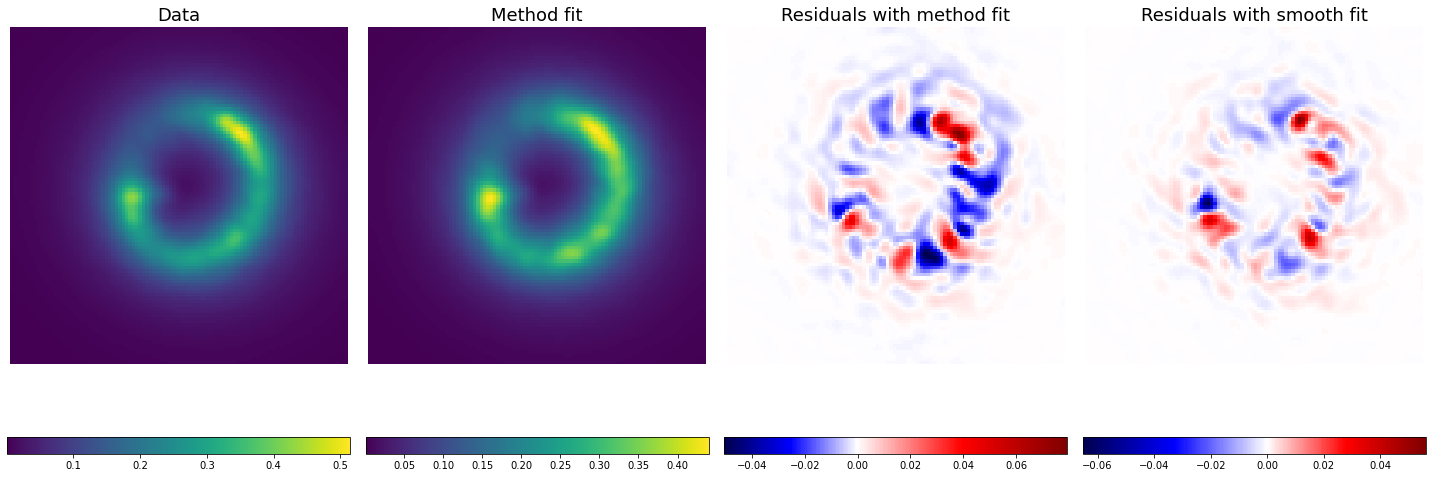

In [ ]:
kwargs0=parameters.args2kwargs(args0)
model0=smooth_lens_image.model(kwargs_lens=kwargs0['kwargs_lens'],
                          kwargs_source=kwargs0['kwargs_source'],
                          kwargs_lens_light=kwargs0['kwargs_lens_light'])

# Plot
fig, ax = plt.subplots(1, 4, figsize=(20, 7))
im0=ax[0].imshow(image, origin='lower')
ax[0].set_title("Data", fontsize=FS)

im1=ax[1].imshow(image_sim, origin='lower')
ax[1].set_title("Method fit", fontsize=FS)

im2=ax[2].imshow((image-image_sim),origin='lower',cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))
ax[2].set_title('Residuals with method fit', fontsize=FS)

im3=ax[3].imshow(resid0,origin='lower',cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))
ax[3].set_title('Residuals with smooth fit', fontsize=FS)

for i in range(4):
  ax[i].axis('off')

for img, ax in zip((im0, im1, im2,im3), ax):
    fig.colorbar(img, ax=ax,orientation='horizontal')
#fig.colorbar(im, ax=ax[-1])
fig.tight_layout()
plt.show()

In [ ]:
Method_resid_spectrum=compute_radial_spetrum(image-image_sim)

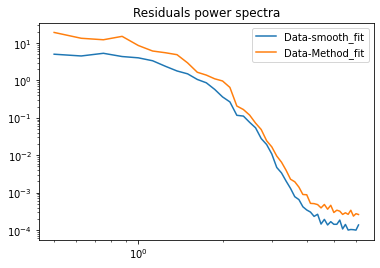

In [ ]:
plt.loglog(masked_k,resid0_spectrum,label='Data-smooth_fit')
plt.loglog(masked_k,Method_resid_spectrum,label='Data-Method_fit')
plt.legend()
plt.title('Residuals power spectra')
plt.show()

In [ ]:
GRF_LensModel=LensModel(['PIXELATED'])


In [ ]:
true_kappa=lens_mass_model.kappa(xgrid,ygrid,kwargs_lens_mass,k=2)*mask
fit_kappa=lens_mass_model.kappa(xgrid,ygrid,kwargs_lens_mass_sim,k=2)*mask

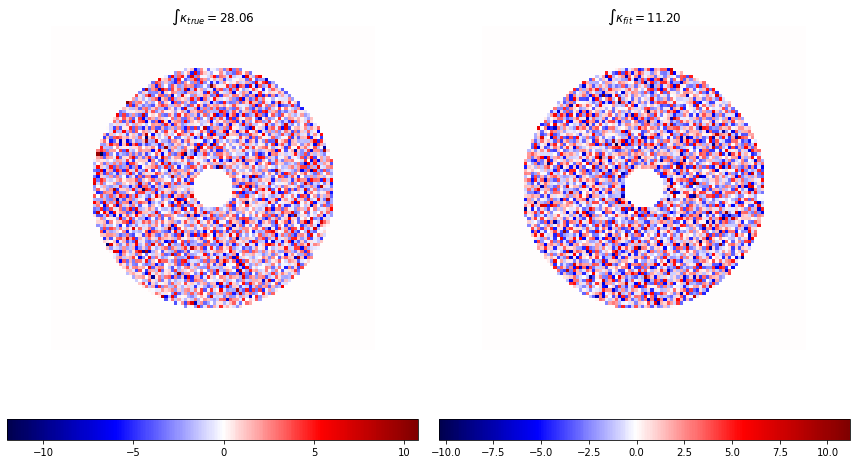

In [ ]:
fig,ax=plt.subplots(1,2,figsize=(12,7))
im0=ax[0].imshow(true_kappa,origin='lower',cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))
ax[0].set_title(r'$\int \kappa_{true}=$'+'{:.2f}'.format(true_kappa.sum()))
im1=ax[1].imshow(fit_kappa,origin='lower',cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))
ax[1].set_title(r'$\int \kappa_{fit}=$'+'{:.2f}'.format(fit_kappa.sum()))

for i in range(2):
  ax[i].axis('off')

for img, ax in zip((im0, im1), ax):
    fig.colorbar(img, ax=ax,orientation='horizontal')

fig.tight_layout()
plt.show()

#### Large scale perturbations

In [ ]:
# Lens mass
lens_mass_model_list = ['SIE', 'SHEAR','PIXELATED']
lens_mass_model = LensModel(lens_mass_model_list)

GRF_Amp=1e-5
GRF_beta=7
GRF_seed=1
GRF_realisation=deepcopy(get_GRF_potential(GRF_Amp,GRF_beta,seed=GRF_seed))
kwargs_lens_mass = [{'theta_E': 1.6, 'e1': 0.15, 'e2': -0.04, 'center_x': 0.0, 'center_y': 0.0},\
                    {'gamma1': -0.01, 'gamma2': 0.03, 'ra_0': 0.0, 'dec_0': 0.0},\
                    {'x_coords': x_coords, 'y_coords': y_coords, 'psi_grid': GRF_realisation}]

# Lens light
lens_light_model_list = []
lens_light_model = LightModel(lens_light_model_list)
kwargs_lens_light = [{}]

In [ ]:
kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': 0.3}
psf = PSF(**kwargs_psf)

exp_time = 2028
SNR=100

#SNR-defined noise
kwargs_numerics = {'supersampling_factor': 1}
lens_image = LensImage(pixel_grid, psf, noise_class={'background_rms': np.zeros((npix, npix)), 'exposure_time': exp_time},
                         lens_model_class=lens_mass_model,
                         source_model_class=source_light_model,
                         lens_light_model_class=lens_light_model,
                         kwargs_numerics=kwargs_numerics)

image=lens_image.model(kwargs_lens=kwargs_lens_mass,
                          kwargs_source=kwargs_source_light,
                          kwargs_lens_light=kwargs_lens_light)

Peak_signal=np.abs(image).max()
sigma_bkd = Peak_signal/SNR
noise_map = sigma_bkd * np.ones((npix, npix))
noise = Noise(npix, npix, **{'background_rms': sigma_bkd, 'exposure_time': exp_time})

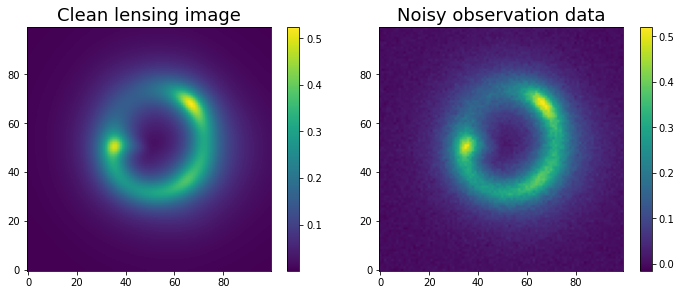

In [ ]:
# Generate a lensed image based on source and lens models
kwargs_numerics = {'supersampling_factor': 1}
lens_image = LensImage(pixel_grid, psf, noise_class=noise,
                         lens_model_class=lens_mass_model,
                         source_model_class=source_light_model,
                         lens_light_model_class=lens_light_model,
                         kwargs_numerics=kwargs_numerics)

image = lens_image.model(kwargs_lens=kwargs_lens_mass,
                          kwargs_source=kwargs_source_light,
                          kwargs_lens_light=kwargs_lens_light)

true_source = lens_image.source_surface_brightness(kwargs_source=kwargs_source_light, 
                                                   de_lensed=True, unconvolved=True)

# Observed noisy data
data = lens_image.simulation(kwargs_lens=kwargs_lens_mass,
                              kwargs_source=kwargs_source_light,
                              kwargs_lens_light=kwargs_lens_light)

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
img1 = ax1.imshow(image, origin='lower')
ax1.set_title("Clean lensing image", fontsize=FS)
img2 = ax2.imshow(data, origin='lower')
ax2.set_title("Noisy observation data", fontsize=FS)
for img, ax in zip((img1, img2), (ax1, ax2)):
    fig.colorbar(img, ax=ax)
fig.tight_layout()

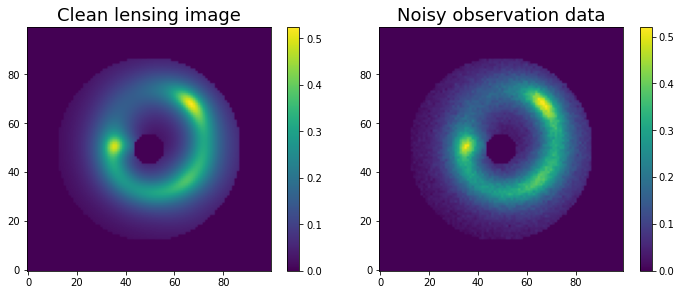

In [ ]:
rmin = 0.5
rmax = 3
radius = np.hypot(xgrid, ygrid)
#Mask covering Einstein ring
mask = ((radius >= rmin) & (radius <= rmax)).astype(bool)

#Account for frequencies present according to size of masked region 
k=np.fft.fftshift(np.fft.fftfreq(mask.shape[0],pix_scl))[image.shape[0]//2:]
mask_spectral_cut_index=np.where(k>1/(rmax-rmin))[0][0]
masked_k=k[mask_spectral_cut_index:]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
img1 = ax1.imshow(image*mask, origin='lower')
ax1.set_title("Clean lensing image", fontsize=FS)
img2 = ax2.imshow(data*mask, origin='lower')
ax2.set_title("Noisy observation data", fontsize=FS)
for img, ax in zip((img1, img2), (ax1, ax2)):
    fig.colorbar(img, ax=ax)
fig.tight_layout()

In [ ]:
kwargs_true={'kwargs_lens':kwargs_lens_mass[:-1],'kwargs_lens_light':kwargs_lens_light,'kwargs_source':kwargs_source_light}

In [ ]:
smooth_lens_image,_=get_model(kwargs_true)
parameters=get_parameters(kwargs_true)
args0,fisher_matrix0=fit_data(image,smooth_lens_image,parameters)

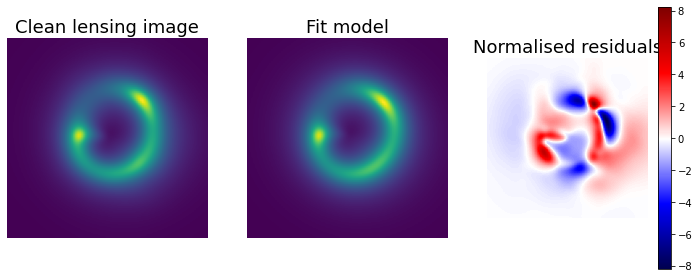

In [ ]:
kwargs0=parameters.args2kwargs(args0)
model0=smooth_lens_image.model(kwargs_lens=kwargs0['kwargs_lens'],
                          kwargs_source=kwargs0['kwargs_source'],
                          kwargs_lens_light=kwargs0['kwargs_lens_light'])

# Plot
fig, ax = plt.subplots(1, 3, figsize=(10, 4))
ax[0].imshow(image, origin='lower')
ax[0].set_title("Clean lensing image", fontsize=FS)

ax[1].imshow(model0, origin='lower')
ax[1].set_title("Fit model", fontsize=FS)

resid0=(image-model0)
im=ax[2].imshow(resid0/sigma_bkd,origin='lower',cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))
ax[2].set_title("Normalised residuals", fontsize=FS)

for i in range(3):
  ax[i].axis('off')


fig.colorbar(im, ax=ax[-1])
fig.tight_layout()
plt.show()

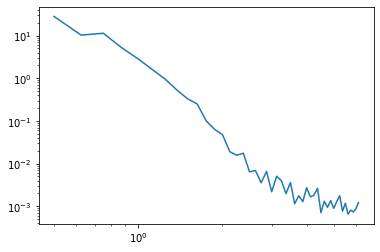

In [ ]:
resid0_spectrum=compute_radial_spetrum(resid0)
plt.loglog(masked_k,resid0_spectrum)

In [ ]:
popt,_ = curve_fit(lambda k,A,beta: A*np.power(k,-beta),masked_k,resid0_spectrum)
popt

array([2.95949733, 3.22344937])

In [ ]:

fit_Amplitude=1.5e-4
fit_Beta=3.223
fit_seed=2
res=minimize(fun=GRF_Loss,x0=(fit_Amplitude,fit_Beta),args=(fit_seed,kwargs0,lens_image,resid0_spectrum),method='Nelder-Mead',options={'disp':True})

loss 9.600370581362137
fit_Amplitude 0.00015
fit_Beta 3.223
loss 8.520936902326943
fit_Amplitude 0.00015749999999999998
fit_Beta 3.223
loss 8.502529424603301
fit_Amplitude 0.00015
fit_Beta 3.38415
loss 7.537408465793293
fit_Amplitude 0.00015749999999999995
fit_Beta 3.38415
loss 6.640770598194323
fit_Amplitude 0.00016124999999999994
fit_Beta 3.4647249999999996
loss 6.446949527374538
fit_Amplitude 0.00015374999999999992
fit_Beta 3.6258749999999997
loss 5.3849995338426
fit_Amplitude 0.00015187499999999988
fit_Beta 3.8273124999999997
loss 4.074965870126445
fit_Amplitude 0.00016312499999999983
fit_Beta 3.9078874999999993
loss 2.592564861272861
fit_Amplitude 0.00016968749999999975
fit_Beta 4.169756249999999
loss 1.6445501457768363
fit_Amplitude 0.0001603124999999997
fit_Beta 4.532343749999999
loss 0.5190326597017159
fit_Amplitude 0.0001598437499999996
fit_Beta 5.066153125
loss 0.32400342333339
fit_Amplitude 0.00017765624999999948
fit_Beta 5.408596874999999
loss 0.6411445332598834
fit_Amplitu

In [ ]:
res.x

array([2.79656255e-06, 8.26039303e+00])

In [ ]:
fit_Amplitude,fit_Beta=res.x
fit_GRF=deepcopy(get_GRF_potential(fit_Amplitude,fit_Beta,seed=fit_seed))

#kwargs_lens_mass_sim = kwargs0['kwargs_lens']+[{'x_coords': x_coords, 'y_coords': y_coords, 'psi_grid': fit_GRF}]
kwargs_lens_mass_sim = kwargs0['kwargs_lens']+[{'x_coords': x_coords, 'y_coords': y_coords, 'psi_grid': fit_GRF}]

image_sim=lens_image.model(kwargs_lens=kwargs_lens_mass_sim,
                          kwargs_source=kwargs0['kwargs_source'],
                          kwargs_lens_light=kwargs0['kwargs_lens_light'])

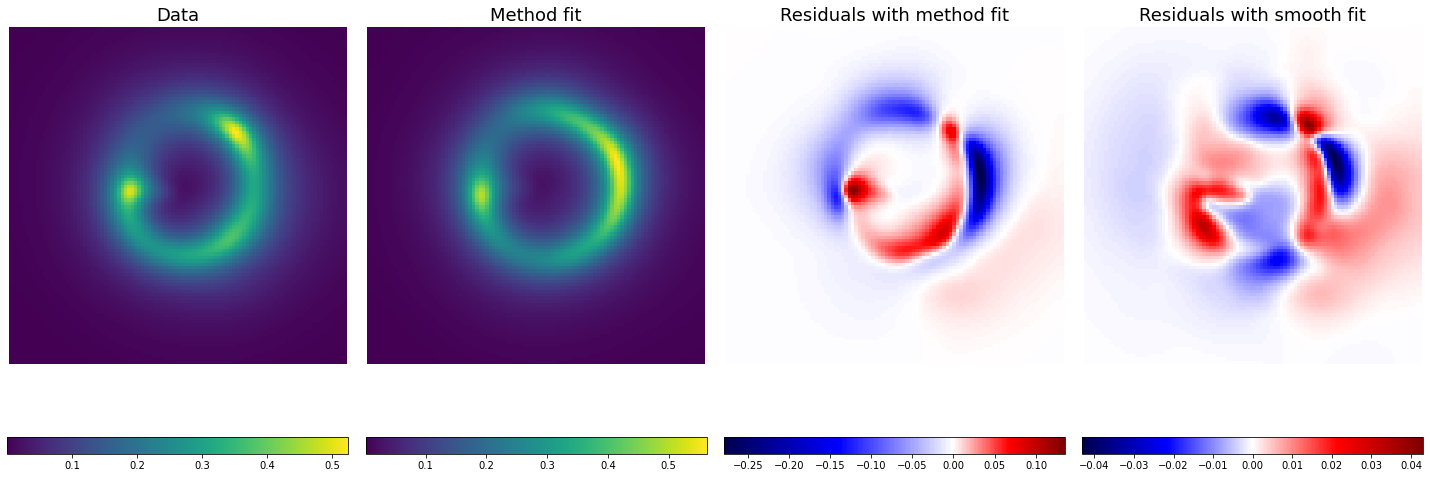

In [ ]:
kwargs0=parameters.args2kwargs(args0)
model0=smooth_lens_image.model(kwargs_lens=kwargs0['kwargs_lens'],
                          kwargs_source=kwargs0['kwargs_source'],
                          kwargs_lens_light=kwargs0['kwargs_lens_light'])

# Plot
fig, ax = plt.subplots(1, 4, figsize=(20, 7))
im0=ax[0].imshow(image, origin='lower')
ax[0].set_title("Data", fontsize=FS)

im1=ax[1].imshow(image_sim, origin='lower')
ax[1].set_title("Method fit", fontsize=FS)

im2=ax[2].imshow((image-image_sim),origin='lower',cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))
ax[2].set_title('Residuals with method fit', fontsize=FS)

im3=ax[3].imshow(resid0,origin='lower',cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))
ax[3].set_title('Residuals with smooth fit', fontsize=FS)

for i in range(4):
  ax[i].axis('off')

for img, ax in zip((im0, im1, im2,im3), ax):
    fig.colorbar(img, ax=ax,orientation='horizontal')
#fig.colorbar(im, ax=ax[-1])
fig.tight_layout()
plt.show()

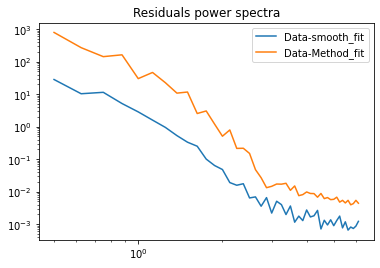

In [ ]:
Method_resid_spectrum=compute_radial_spetrum(image-image_sim)
plt.loglog(masked_k,resid0_spectrum,label='Data-smooth_fit')
plt.loglog(masked_k,Method_resid_spectrum,label='Data-Method_fit')
plt.legend()
plt.title('Residuals power spectra')
plt.show()

In [ ]:
true_kappa=lens_mass_model.kappa(xgrid,ygrid,kwargs_lens_mass,k=2)*mask
fit_kappa=lens_mass_model.kappa(xgrid,ygrid,kwargs_lens_mass_sim,k=2)*mask

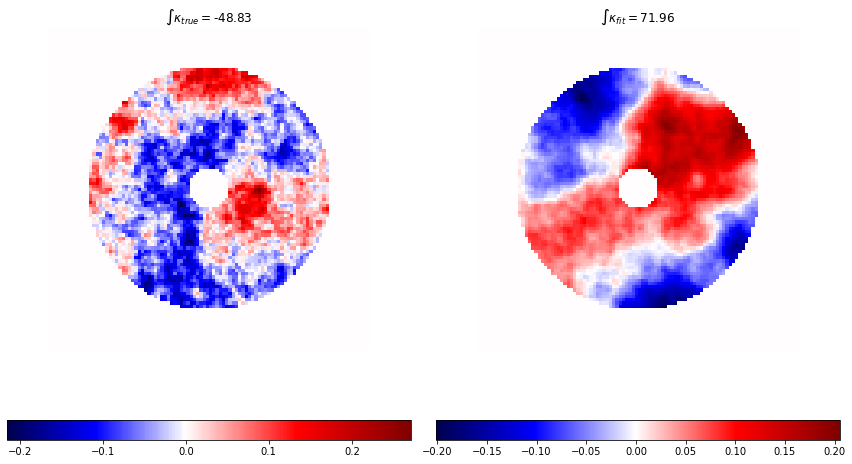

In [ ]:
fig,ax=plt.subplots(1,2,figsize=(12,7))
im0=ax[0].imshow(true_kappa,origin='lower',cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))
ax[0].set_title(r'$\int \kappa_{true}=$'+'{:.2f}'.format(true_kappa.sum()))
im1=ax[1].imshow(fit_kappa,origin='lower',cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))
ax[1].set_title(r'$\int \kappa_{fit}=$'+'{:.2f}'.format(fit_kappa.sum()))

for i in range(2):
  ax[i].axis('off')

for img, ax in zip((im0, im1), ax):
    fig.colorbar(img, ax=ax,orientation='horizontal')

fig.tight_layout()
plt.show()

## Pixelated source fitting Model for fitting

In [ ]:
# Recreate a Noise object with true noise map
kwargs_noise_fit = {'background_rms': sigma_bkd, 'noise_map': noise_map}
fit_noise = Noise(npix, npix, **kwargs_noise_fit)

# Change only the source light model
fit_source_light_model_list = ['PIXELATED']
kwargs_pixelated_source = {
    'pixel_scale_factor': 0.5, # scaling factor for source pixel size
}
fit_source_light_model = LightModel(fit_source_light_model_list,
                                    kwargs_pixelated=kwargs_pixelated_source)
fit_lens_image = LensImage(pixel_grid, psf, noise_class=fit_noise,
                             lens_model_class=lens_mass_model,
                             source_model_class=fit_source_light_model,
                             lens_light_model_class=lens_light_model,
                             kwargs_numerics=kwargs_numerics)

# 1D coordinate arrays for source grid interpolation
x_coords = fit_lens_image.Grid.pixel_coordinates[0][0, :]
y_coords = fit_lens_image.Grid.pixel_coordinates[1][:, 0]

In [ ]:
kwargs_model = {
    'lens_model_list': lens_mass_model_list,
    'source_model_list': fit_source_light_model_list,
    'lens_light_model_list': lens_light_model_list,
}
kwargs_init = {
    'kwargs_lens': [{'theta_E': 1.5, 'e1': 0.1, 'e2': -0.05, 'center_x': 1e-3, 'center_y': 1e-3}, {'gamma1': -0.02, 'gamma2': 0.02}],
    'kwargs_source': [{'pixels': 1e-8}],
}
kwargs_prior = {
    'kwargs_lens': [{}, {}],
    'kwargs_source': [{}],
}
kwargs_fixed = {
    # we still fix the lens center, because in practice it is constrained by the lens light
    'kwargs_lens': [{'center_x': 0., 'center_y': 0.}, {'ra_0': 0., 'dec_0': 0.}],
    # uncomment the following line to fix all lens parameters
    #'kwargs_lens': kwargs_lens_mass,
    'kwargs_source': [{}],
}
parameters = Parameters(fit_lens_image, kwargs_init, kwargs_prior, kwargs_fixed)
print("num. parameters:", parameters.num_parameters)

num. parameters: 40005


In [ ]:
loss = Loss(data, fit_lens_image, parameters, 
            likelihood_type='l2_norm',
            regularization_terms=['l1_starlet_source', 
                                  'l1_battle_source',
                                  'positivity_source'], 
            regularization_strengths=[(5, 3), 3, 3],
            prior_terms=None)
optimizer = Optimizer(loss, parameters)
print(f"Initial loss: {optimizer.loss(parameters.initial_values()):.2f}")
print("Data points used in likelihood:", loss.likelihood_num_data_points)

Initial loss: 6.09
Data points used in likelihood: 10000


### Optax optimization

In [ ]:
best_fit, logL_best_fit, extra_fields, runtime \
    = optimizer.optax(max_iterations=500, 
                      init_learning_rate=1e-2,
                      restart_from_init=True)
print(f"Runtime: {runtime} s")
print(f"Final loss: {logL_best_fit:.2f}")
kwargs_final = parameters.best_fit_values(as_kwargs=True)

Runtime: 94.08741307258606 s
Final loss: 2.12


/content/drive/My Drive/Jax_Strong_Lensing//Modules/Aymeric_repo/jaxtronomy/Analysis/plot.py:114: UserWarning: True source array has been interpolated to match model array
  warnings.warn("True source array has been interpolated to match model array")


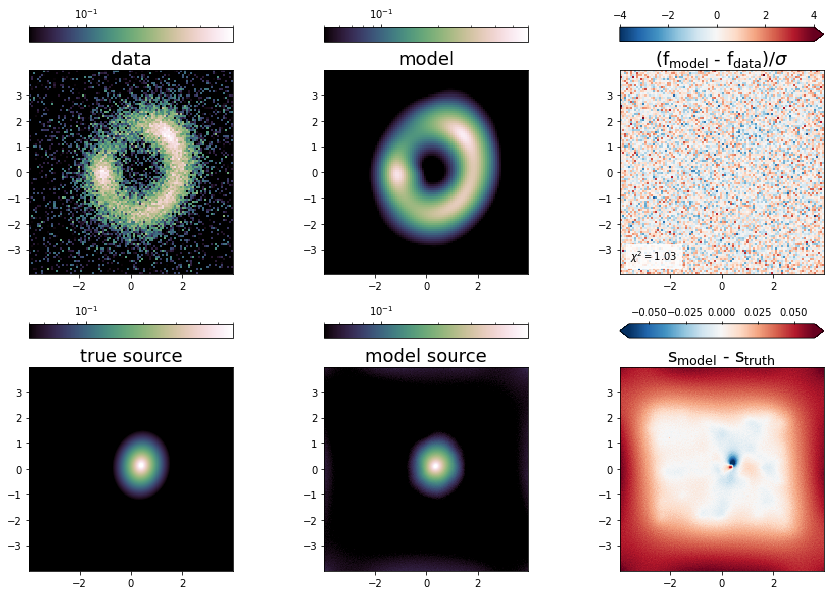

In [ ]:
plotter = Plotter(base_fontsize=FS, flux_vmin=5e-2, flux_vmax=6e-1)
plotter.set_data(data)
plotter.set_true_source(true_source)
plotter.model_summary(fit_lens_image, kwargs_final,
                      likelihood_mask=loss.likelihood_mask)

In [ ]:
def print_errors(kwargs):
    def _print_error(name, value, estimate):
        spaces = " " * (10 - len(name))
        if value != 0:
            error = 100 * abs(value - estimate) / value
            print(name + ":" + spaces + f"{error:.2f} % ({value} => {estimate})")
        else:
            error = abs(value - estimate)
            print(name + ":" + spaces + f"{error:.2f} [abs] ({value} => {estimate})")
    print("Error")
    print("-----")
    for i, params in enumerate(kwargs_lens_mass):
        for key, value in params.items():
            fit = kwargs['kwargs_lens'][i][key]
            _print_error(key, value, fit)
        
print_errors(kwargs_final)

Error
-----
theta_E:   0.14 % (1.6 => 1.6023093467483056)
e1:        32.22 % (0.15 => 0.1016653984586267)
e2:        -77.95 % (-0.04 => -0.008819196707419444)
center_x:  0.00 [abs] (0.0 => 0.0)
center_y:  0.00 [abs] (0.0 => 0.0)
gamma1:    -282.18 % (-0.01 => -0.038217769215582745)
gamma2:    47.91 % (0.03 => 0.044374051739819065)
ra_0:      0.00 [abs] (0.0 => 0.0)
dec_0:     0.00 [abs] (0.0 => 0.0)
